In [1]:
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
train_dir = pathlib.Path("chest_xray/train")
test_dir =  pathlib.Path("chest_xray/test")

In [5]:
train_count = len(list(train_dir.glob('*/*.jpeg')))
test_count = len(list(test_dir.glob('*/*.jpeg')))
print(train_count)
print(test_count)

5216
624


In [6]:
train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'), shuffle=False)
train_ds = train_ds.shuffle(train_count, reshuffle_each_iteration=False)

In [7]:
test_ds = tf.data.Dataset.list_files(str(test_dir/'*/*'), shuffle=False)
test_ds = test_ds.shuffle(test_count, reshuffle_each_iteration=False)

In [8]:
for f in train_ds.take(5):
  print(f.numpy())

b'chest_xray/train/NORMAL/NORMAL2-IM-1088-0001.jpeg'
b'chest_xray/train/NORMAL/NORMAL2-IM-0825-0001.jpeg'
b'chest_xray/train/PNEUMONIA/person882_bacteria_2806.jpeg'
b'chest_xray/train/PNEUMONIA/person1089_virus_1808.jpeg'
b'chest_xray/train/NORMAL/NORMAL2-IM-0741-0001.jpeg'


In [9]:
for f in test_ds.take(5):
  print(f.numpy())

b'chest_xray/test/PNEUMONIA/person118_bacteria_559.jpeg'
b'chest_xray/test/NORMAL/NORMAL2-IM-0081-0001.jpeg'
b'chest_xray/test/PNEUMONIA/person1680_virus_2897.jpeg'
b'chest_xray/test/PNEUMONIA/person45_virus_95.jpeg'
b'chest_xray/test/PNEUMONIA/person1_virus_7.jpeg'


In [10]:
class_names = np.array(sorted([item.name for item in train_dir.glob('*') if item.name != ".DS_Store"]))
print(class_names)

['NORMAL' 'PNEUMONIA']


In [11]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

5216
624


In [12]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [13]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [15]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
test_ds = configure_for_performance(test_ds)

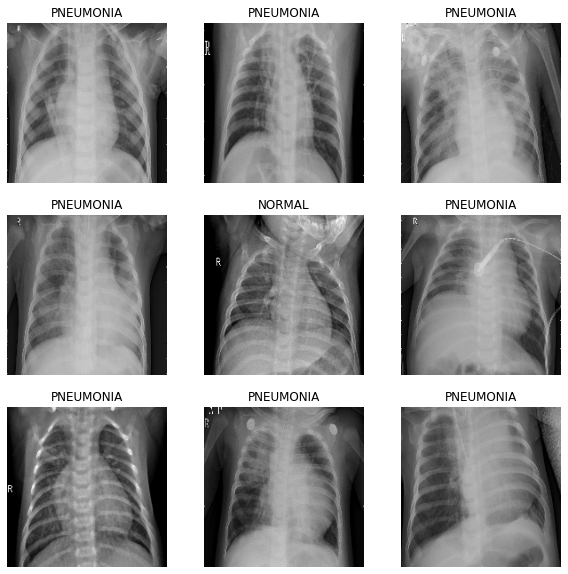

In [16]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [17]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.RandomZoom(.2),
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomRotation(factor=30),
    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)

In [19]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
  loss=tf.losses.BinaryCrossentropy(from_logits=False),
  metrics=['binary_accuracy'])

In [20]:
history = model.fit(
  train_ds,
  validation_data=test_ds,
  callbacks = [early_stopping],
  epochs=100
)

Epoch 1/100
163/163 [==============================] - 27s 116ms/step - loss: 0.6947 - binary_accuracy: 0.6902 - val_loss: 1.3167 - val_binary_accuracy: 0.6250
Epoch 2/100
163/163 [==============================] - 9s 58ms/step - loss: 0.3823 - binary_accuracy: 0.8374 - val_loss: 2.0625 - val_binary_accuracy: 0.6250
Epoch 3/100
163/163 [==============================] - 9s 58ms/step - loss: 0.2988 - binary_accuracy: 0.8761 - val_loss: 1.6006 - val_binary_accuracy: 0.6250
Epoch 4/100
163/163 [==============================] - 9s 58ms/step - loss: 0.2851 - binary_accuracy: 0.8801 - val_loss: 0.7581 - val_binary_accuracy: 0.7083
Epoch 5/100
163/163 [==============================] - 9s 58ms/step - loss: 0.2710 - binary_accuracy: 0.8946 - val_loss: 0.4134 - val_binary_accuracy: 0.8397
Epoch 6/100
163/163 [==============================] - 9s 58ms/step - loss: 0.2536 - binary_accuracy: 0.8962 - val_loss: 0.3806 - val_binary_accuracy: 0.8494
Epoch 7/100
163/163 [=============================

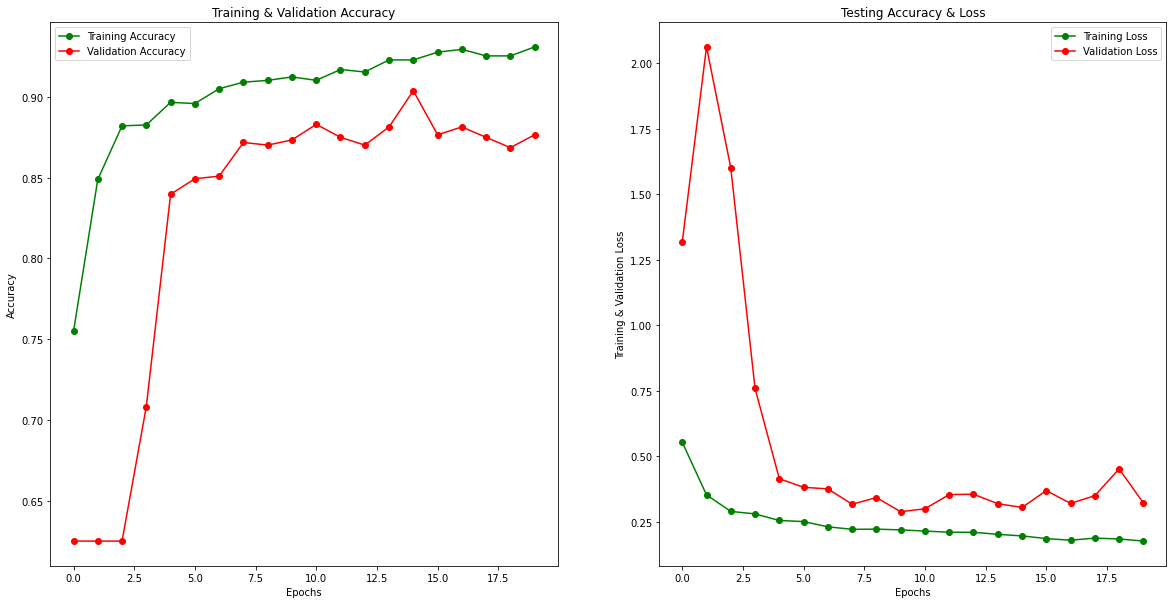

In [22]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['binary_accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_binary_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 180, 180, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 128)     3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 178, 178, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 128)       0